On the importance of operational significance: the case of PIF
==============================================================

**Author:** Luigi D. C. Soares



## Required Libraries



In [18]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

from piflib import pif_calculator as pif

import sys
sys.path.append('/home/luigi/workspace/topete/pif')

import qif
import utils

## The Hackathon Dataset



### Building the Dataset



In [19]:
features = ['gender', 'AGE', 'POSTCODE', 'blood_group', 'eye_color', 'job']

df = pd.read_csv('hackathon.csv')[features].fillna('Unemployed')
pd.concat([df.head(3), df.tail(3)])

,gender,AGE,POSTCODE,blood_group,eye_color,job
0,F,99,2649,B-,Brown,"Psychologist, counselling"
1,M,108,1780,A-,Hazel,Personnel officer
2,M,59,2940,B+,Hazel,Tourism officer
38459,F,19,2848,AB-,Brown,Student
38460,M,60,2630,A-,Brown,Data scientist
38461,F,58,2017,O-,Green,Dramatherapist


In [20]:
df.value_counts(subset=features[1:])

AGE  POSTCODE  blood_group  eye_color  job                                   
7    2920      AB-          Brown      Unemployed                                3
     2619      A+           Blue       Unemployed                                3
16   2619      A+           Hazel      Unemployed                                3
21   2920      A-           Brown      Student                                   2
4    2920      B+           Blue       Unemployed                                2
                                                                                ..
39   1811      B-           Hazel      Civil engineer, consulting                1
     1896      B-           Grey       Facilities manager                        1
     1936      O-           Blue       Community pharmacist                      1
     2001      O+           Blue       Operational investment banker             1
116  6053      A+           Hazel      Teacher, English as a foreign language    1
Length: 3

In [21]:
df.query('AGE == 7 & POSTCODE == 2920 & blood_group == "AB-" & eye_color == "Brown" & job == "Unemployed"')

,gender,AGE,POSTCODE,blood_group,eye_color,job
9186,M,7,2920,AB-,Brown,Unemployed
17129,M,7,2920,AB-,Brown,Unemployed
28491,M,7,2920,AB-,Brown,Unemployed


### Base Measure: CIG (KL divergence)



In [22]:
cigs = pif.compute_cigs(df)
pd.concat([cigs.head(3), cigs.tail(3)])

,gender,AGE,POSTCODE,blood_group,eye_color,job
0,0.950303,6.895756,8.788203,3.003530,2.330845,9.739293
1,1.051470,6.969051,14.231146,2.991846,2.311166,9.838829
2,1.051470,6.983219,8.838829,2.977890,2.311166,9.707584
38459,0.950303,6.945744,7.694697,3.015613,2.330845,4.931938
38460,1.051470,6.918263,8.631233,2.991846,2.330845,9.707584
38461,0.950303,6.983219,12.231146,3.011675,2.310979,9.476259


<AxesSubplot: >

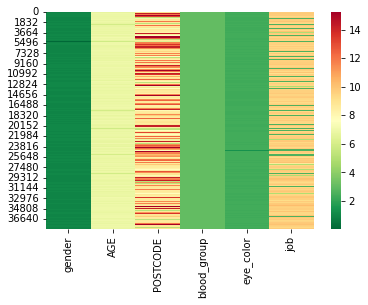

In [23]:
color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1]
)

sns.heatmap(cigs, cmap = color_map)

### Individual Attack: CIG vs Bayes



In [24]:
def prepare_qif(pi, C):
    '''
    Transform the prior pi and channel C into the format
    required by Kostas' QIF library (i.e. without keys)
    '''
    return list(pi.values()), C.values


def bayes_cells(df, channel, prior):
    bayes_dfs = []
    for secret in df.columns:
        qids = [feature for feature in df.columns if feature != secret]
        C = channel[secret]

        Y = C.columns.tolist()
        pi, C = prepare_qif(prior[secret], C)

        inner_vuln = {}

        # We assume that there's a direct map between the index of the output
        # y in Y and the index of the posterior computed by the qif library.
        # (is this really guaranteed???)
        for i, y in enumerate(Y):
            # Use prior Bayes vuln since we're computing the Bayes of each
            # inner distribution, not the average on the inners.
            delta_i = qif.channel.posterior(C, pi, i)
            inner_vuln[y] = qif.measure.bayes_vuln.prior(delta_i)

        column = []
        for record in df.to_dict('records'):
            y = tuple(record[feature] for feature in qids)
            column.append(inner_vuln[y])

        bayes_dfs.append(pd.DataFrame({secret: column}))

    return pd.concat(bayes_dfs, axis=1)

In [25]:
channel = {}
prior = {}

for secret in df.columns:
    pi, C = utils.channel.from_data(df, secret)
    channel[secret] = C
    prior[secret] = pi

<AxesSubplot: >

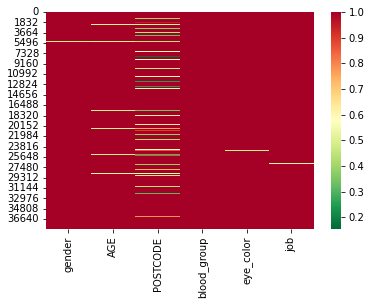

In [26]:
bayes = bayes_cells(df, channel, prior)

color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1])

sns.heatmap(bayes, cmap = color_map)

### Attribute Inference: FIG vs Bayes



In [27]:
figs = cigs.sum(axis = 0)
figs

gender          38342.403804
AGE            262612.319072
POSTCODE       386886.543373
blood_group    114904.504519
eye_color       88981.301492
job            319484.856776
dtype: float64

    ['gender', 'AGE', 'POSTCODE', 'blood_group', 'eye_color', 'job']



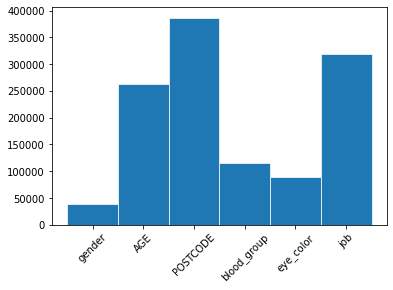

In [29]:
x = df.columns
y = [figs[secret] for secret in df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

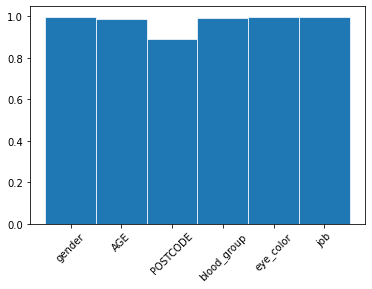

In [30]:
post_bayes = lambda secret: qif.measure.bayes_vuln.posterior(
    *prepare_qif(prior[secret], channel[secret]))

x = df.columns
y = [post_bayes(secret) for secret in df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

### Alternative Measure: CSF



In [31]:
csfs = pif.compute_csfs(df)
csfs.describe()

,gender,AGE,POSTCODE,blood_group,eye_color,job
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.498328,0.977707,0.846887,0.869045,0.795840,0.966596
std,0.028408,0.086362,0.307341,0.056100,0.045859,0.074689
min,0.017524,0.133263,0.049805,0.073070,0.131810,0.331747
25%,0.482476,0.990952,0.996880,0.873252,0.798502,0.998414
50%,0.482476,0.991394,0.997660,0.874682,0.800348,0.998648
75%,0.517524,0.991654,0.999740,0.876007,0.801232,0.998804
max,0.517524,0.999740,0.999974,0.877047,0.801440,0.999402


<AxesSubplot: >

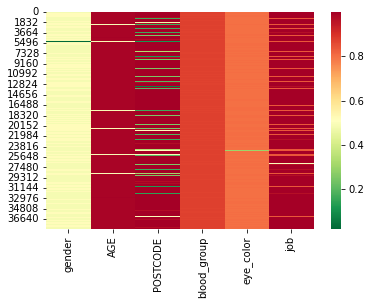

In [32]:
color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1]
)

sns.heatmap(csfs, cmap = color_map)

Following the PIF tutorial, we remove POSTCODE and Job to try to reduce the numbers:



In [33]:
sub_df = df.drop(['POSTCODE', 'job'], axis=1)
csfs = pif.compute_csfs(sub_df)
csfs.describe()

,gender,AGE,blood_group,eye_color
count,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.136386,0.003600,0.048995,0.072766
std,0.104873,0.003025,0.041834,0.059569
min,0.006286,0.000001,0.000305,0.000348
25%,0.053905,0.001375,0.018391,0.027585
50%,0.117524,0.002807,0.039136,0.058666
75%,0.184190,0.005016,0.069355,0.103322
max,0.517524,0.022063,0.877047,0.801440


<AxesSubplot: >

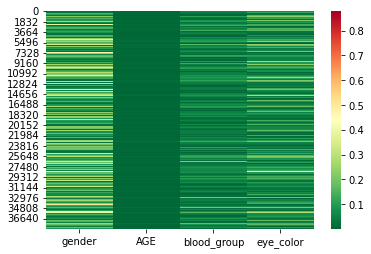

In [34]:
sns.heatmap(csfs, cmap = color_map)

<AxesSubplot: >

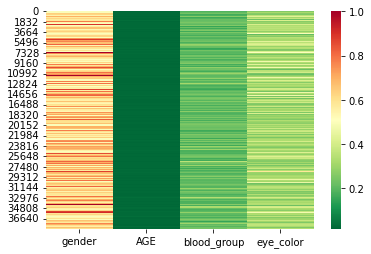

In [35]:
channel = {}
prior = {}

for secret in sub_df.columns:
    pi, C = utils.channel.from_data(sub_df, secret)
    channel[secret] = C
    prior[secret] = pi

bayes = bayes_cells(sub_df, channel, prior)
color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1])
sns.heatmap(bayes, cmap = color_map)

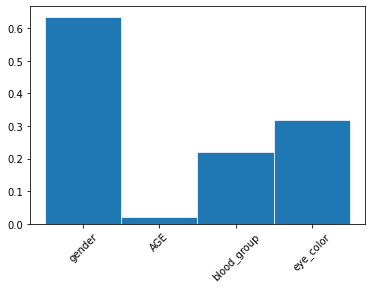

In [36]:
post_bayes = lambda secret: qif.measure.bayes_vuln.posterior(
    *prepare_qif(prior[secret], channel[secret]))

x = sub_df.columns
y = [post_bayes(secret) for secret in sub_df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

It does seem better. The posterior Bayes vuln. of gender is still high, but
it&rsquo;s close to the prior (+- 0.5, since gender has only two elements), so the
leakage is small. But, let&rsquo;s take a look at the original dataset again:



In [37]:
csfs = pif.compute_csfs(df)
csfs.describe()

,gender,AGE,POSTCODE,blood_group,eye_color,job
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.498328,0.977707,0.846887,0.869045,0.795840,0.966596
std,0.028408,0.086362,0.307341,0.056100,0.045859,0.074689
min,0.017524,0.133263,0.049805,0.073070,0.131810,0.331747
25%,0.482476,0.990952,0.996880,0.873252,0.798502,0.998414
50%,0.482476,0.991394,0.997660,0.874682,0.800348,0.998648
75%,0.517524,0.991654,0.999740,0.876007,0.801232,0.998804
max,0.517524,0.999740,0.999974,0.877047,0.801440,0.999402


Why exactly they decided to drop POSTCODE and job, when the feature with the
highest average is AGE? Why not drop AGE? Let&rsquo;s give it a try:



In [38]:
sub_df = df.drop(['AGE'], axis=1)
csfs = pif.compute_csfs(sub_df)
csfs.describe()

,gender,POSTCODE,blood_group,eye_color,job
count,38462.000000,38462.000000,38462.000000,38462.000000,38462.000000
mean,0.488893,0.604352,0.824001,0.764093,0.714655
std,0.068743,0.382611,0.169502,0.139688,0.322581
min,0.017524,0.000091,0.000305,0.000348,0.002479
25%,0.482476,0.331071,0.873252,0.798476,0.498388
50%,0.482476,0.499818,0.874682,0.800348,0.835812
75%,0.517524,0.997738,0.876007,0.801232,0.998700
max,0.517524,0.999974,0.877047,0.801440,0.999402


<AxesSubplot: >

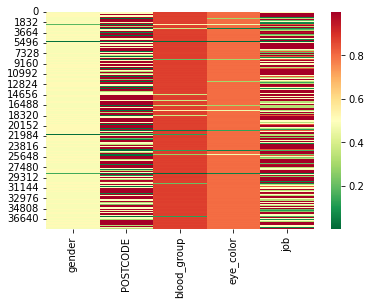

In [39]:
sns.heatmap(csfs, cmap = color_map)

It didn&rsquo;t help that much, so what&rsquo;s the logic behind the decision of dropping POSTCODE and job?
The result looks better in the first approach, but the first approach goes against the CSF numbers.



<AxesSubplot: >

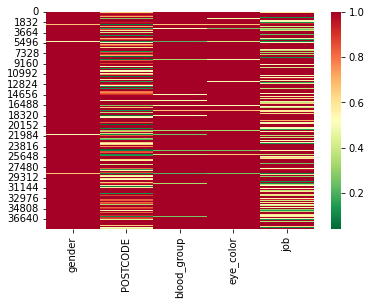

In [40]:
channel = {}
prior = {}

for secret in sub_df.columns:
    pi, C = utils.channel.from_data(sub_df, secret)
    channel[secret] = C
    prior[secret] = pi

bayes = bayes_cells(sub_df, channel, prior)
color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1]
)
sns.heatmap(bayes, cmap = color_map)

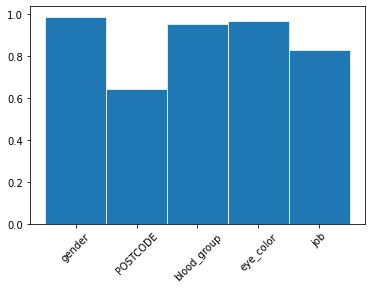

In [41]:
post_bayes = lambda secret: qif.measure.bayes_vuln.posterior(
    *prepare_qif(prior[secret], channel[secret]))

x = sub_df.columns
y = [post_bayes(secret) for secret in sub_df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

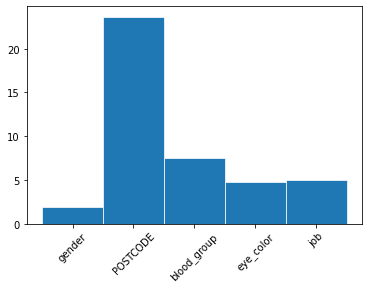

In [42]:
mult_bayes = lambda secret: qif.measure.bayes_vuln.mult_leakage(
    *prepare_qif(prior[secret], channel[secret]))

y = [mult_bayes(secret) for secret in sub_df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

We dropped AGE, since that&rsquo;s what intuitively the CSF numbers suggested, but
we can still (virtually) always infer gender, blood<sub>group</sub> and eye<sub>color</sub> correctly.

Let&rsquo;s try AGE and Job:



In [43]:
sub_df = df.drop(['AGE', 'job'], axis=1)
csfs = pif.compute_csfs(sub_df)
csfs.describe()

,gender,POSTCODE,blood_group,eye_color
count,38462.000000,3.846200e+04,38462.000000,38462.000000
mean,0.342517,2.346209e-03,0.368705,0.392774
std,0.196529,2.005173e-03,0.350299,0.323548
min,0.000995,2.217457e-07,0.000305,0.000348
25%,0.149143,1.611919e-03,0.057826,0.086947
50%,0.482476,1.918495e-03,0.208639,0.298502
75%,0.517524,2.236444e-03,0.873252,0.798502
max,0.517524,2.517782e-02,0.877047,0.801440


<AxesSubplot: >

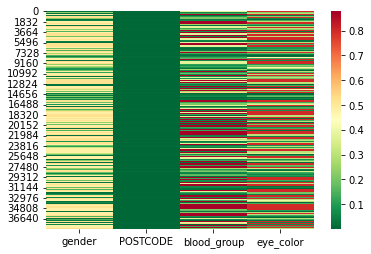

In [44]:
sns.heatmap(csfs, cmap = color_map)

<AxesSubplot: >

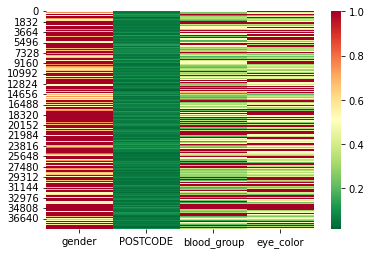

In [45]:
channel = {}
prior = {}

for secret in sub_df.columns:
    pi, C = utils.channel.from_data(sub_df, secret)
    channel[secret] = C
    prior[secret] = pi

bayes = bayes_cells(sub_df, channel, prior)
color_map = colors.ListedColormap(
    sns.color_palette('RdYlGn', 256).as_hex()[::-1]
)
sns.heatmap(bayes, cmap = color_map)

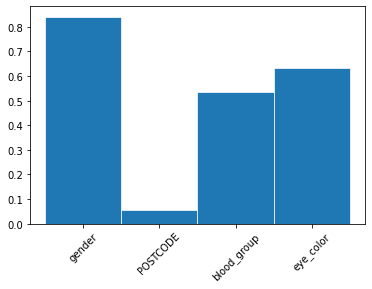

In [46]:
post_bayes = lambda secret: qif.measure.bayes_vuln.posterior(
    *prepare_qif(prior[secret], channel[secret]))

x = sub_df.columns
y = [post_bayes(secret) for secret in sub_df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

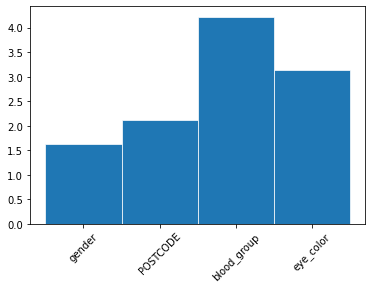

In [47]:
mult_bayes = lambda secret: qif.measure.bayes_vuln.mult_leakage(
    *prepare_qif(prior[secret], channel[secret]))

y = [mult_bayes(secret) for secret in sub_df.columns]

fig, ax = plt.subplots()
ax.bar(x, y, width = 1, edgecolor = 'white', linewidth = 0.7)

plt.xticks(rotation = 45)
plt.show()

Once again, it did help, but not as much as dropping POSTCODE and Job. Why is that?

Also, CSF measures the absolute change in probability for each element of the
secret. Couldn&rsquo;t the change be negative, thus indicating that the risk reduced?

We know that Bayes vuln. can also decrease when we look at the inners individually
(dynamic view), but posterior Bayes vuln. can never decrease. What would be the
&rsquo;posterior&rsquo; version of CSF? How to combine the CSFs? Would that help?

Furthermore, it could be that the probability of an element decreases and the corresponding
CSF is the same of a cel whose element&rsquo;s probability increased. What does that mean?
The individual whose cell&rsquo;s probability decreased is at the same risk as the one whose
cell&rsquo;s probability increased???

Let&rsquo;s see an example. Consider the following dataset:



In [48]:
df_ab = pd.DataFrame({
    'A': ['a1'] * 4 + ['a2'] * 4,
    'B': ['b1'] * 3 + ['b2'] * 4 + ['b1']
})

df_ab

,A,B
0,a1,b1
1,a1,b1
2,a1,b1
3,a1,b2
4,a2,b2
5,a2,b2
6,a2,b2
7,a2,b1


The cell surprise factors are exactly the same for every cell:



In [49]:
csfs_ab = pif.compute_csfs(df_ab)
csfs_ab

,A,B
0,0.25,0.25
1,0.25,0.25
2,0.25,0.25
3,0.25,0.25
4,0.25,0.25
5,0.25,0.25
6,0.25,0.25
7,0.25,0.25


Let A be the sensitive attribute and B the QID known by the adversary.
Then, we have the follwoing prior and channel:



In [50]:
pi, C = utils.channel.from_data(df_ab, 'A')
pi

{'a1': 0.5, 'a2': 0.5}

In [51]:
C

,b1,b2
a1,0.75,0.25
a2,0.25,0.75


and the hyper-distribution (which, coincidentally, is exact the same as the channel):



In [52]:
J = C.apply(lambda p: pi[p.name] * p, axis=1)
Py = J.apply(np.sum, axis=0)
hyper = J.apply(lambda p: p / Py[p.name], axis=0)
hyper

,b1,b2
a1,0.75,0.25
a2,0.25,0.75


Here are changes in probability without taking the absolute value:



In [53]:
hyper.apply(lambda p: p - pi[p.name], axis=1)

,b1,b2
a1,0.25,-0.25
a2,-0.25,0.25


Notice that, at the posterior &ldquo;b1&rdquo;, the change in probability for a1 is 0.25
and for a2 is -0.25. Yet, the corresponding cells receive the same CSF value:
0.25. What does this mean???

